# Feature Engineering for Cyclical Variables using Trigonometric Conversions and Radial Basis Function
This notebook is a feature engineering practice for cyclical variables such as time, day, month etc. The flight delay data will be used here is a part of [mlcourse.ai](https://mlcourse.ai/book/topic10/assignment10_flight_delays_kaggle.html) Topic 10 demo competition.

The task here is to predict if a flight will be delayed for 15 minutes or more. Features include 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'dep_delayed_15min'. The time related features 'Month', 'DayofMonth', 'DayOfWeek', and 'DepTime' are numeric and they seem to be understood linearly if the values were taken as they are. However, for instance 2340 and 0030 departure times should be interpreted very close. Therefore, more nuanced standardization methods are suggested for this problem. This [great article](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/) from [Eryk Lewinson](https://developer.nvidia.com/blog/author/eryklewinson/) was taken as a guide in this work.

## Initial approach

In [1]:
!pip install sklego

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 kB 3.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklego.preprocessing import RepeatingBasisFunction
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('/kaggle/input/flight-delays-spring-2018/flight_delays_train.csv')
test = pd.read_csv('/kaggle/input/flight-delays-spring-2018/flight_delays_test.csv')

train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
# map Y: 1, N: 0 and remove the string values in Month, DayofMonth, DayOfWeek features
train['dep_delayed_15min'] = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
train['DayOfWeek'] = train['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))
train['Month'] = train['Month'].apply(lambda x: int(x.split('-')[1]))
train['DayofMonth'] = train['DayofMonth'].apply(lambda x: int(x.split('-')[1]))

Text(0.5, 1.0, 'Standardized for Month')

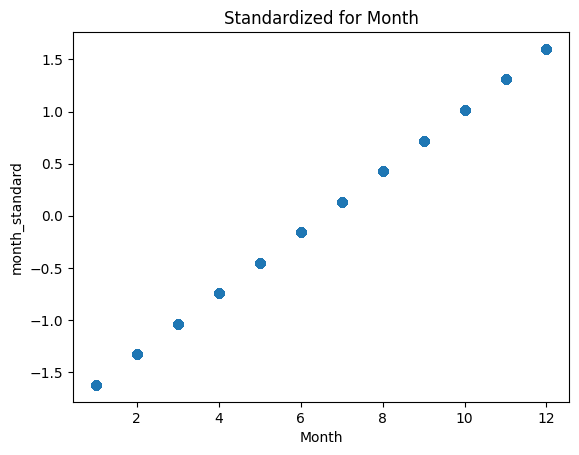

In [5]:
# see why standart scaler is not appropriate for cyclical features:
z = train['Month'].array.reshape(-1, 1)
month_standard = StandardScaler().fit_transform(z)
fig, ax = plt.subplots()
ax.plot(train['Month'], month_standard, 'o')
plt.xlabel('Month')
plt.ylabel('month_standard')
plt.title('Standardized for Month')

As seen above plot, when standardizing Month, middle of the year takes value 0 and it shows the other months are how different than this middle point. But the months are going in cycles, not in linear line. First month of the year should be closer to last month of year. In this linear fashion, they fall on the opposite sides.

### Trigonometric transformations
We can use sin and cos transformations and see which one is more meaningful for the feature. Eventhough, it will be a bit arbitrary to decide which trigonometric function is appropriate for a feature, it should be much better than the linear approach. Fundamentally, trigonometric transformation is not so different than standard scaler, they both transform the values as if some divergence from a set point. But trigonometric transformation can preserve the cyclical nature of the feature. The highest and the lowest values converge together.

In [6]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

Text(0.5, 1.0, 'Sin Transformation for Month')

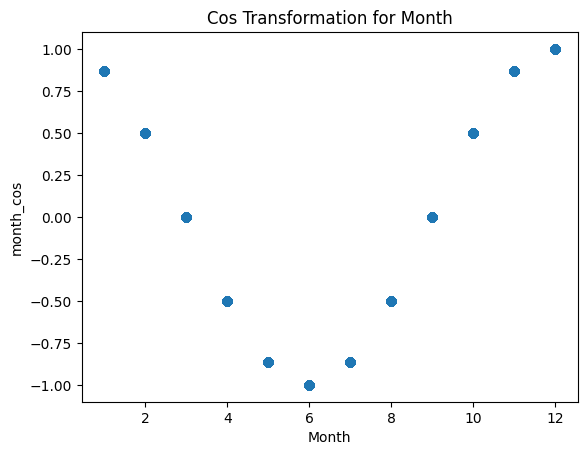

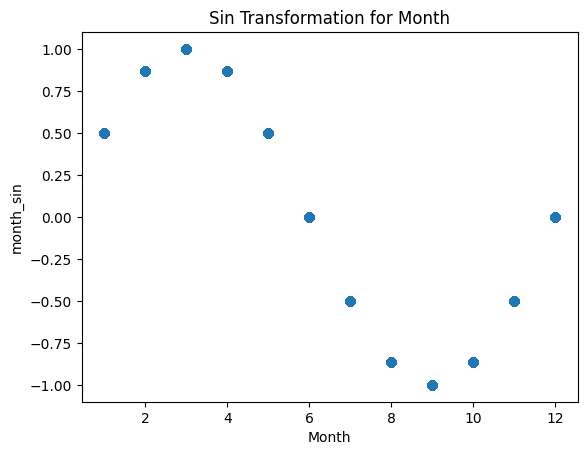

In [7]:
# Trigonometric transformation for Month feature:
month_cos = cos_transformer(12).fit_transform(train['Month'])
fig, ax = plt.subplots()
ax.plot(train['Month'], month_cos, 'o')
plt.xlabel('Month')
plt.ylabel('month_cos')
plt.title('Cos Transformation for Month')

month_sin = sin_transformer(12).fit_transform(train['Month'])
fig, ax = plt.subplots()
ax.plot(train['Month'], month_sin, 'o')
plt.xlabel('Month')
plt.ylabel('month_sin')
plt.title('Sin Transformation for Month')

**For Month, cos transformation suits better.** Months in summer season have closer values, and winter season months approach to the same values.

Text(0.5, 1.0, 'Sin Transformation for DayofMonth')

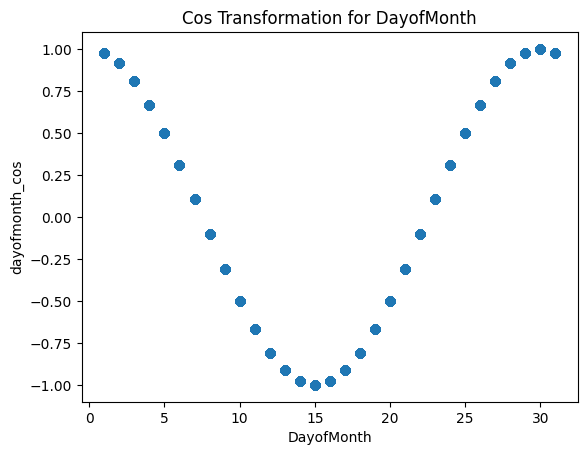

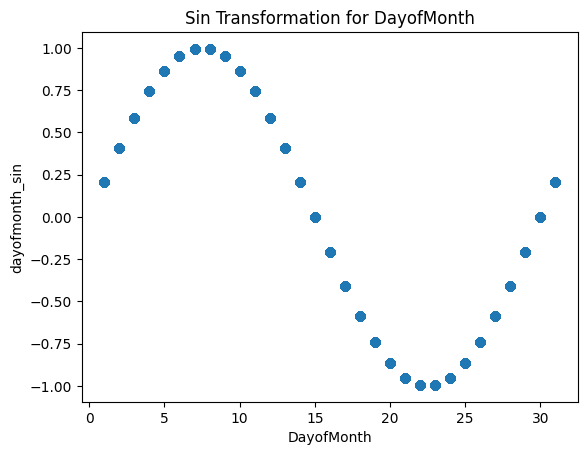

In [8]:
# Trigonometric transformation for DayOfMonth feature:
dayofmonth_cos = cos_transformer(30).fit_transform(train['DayofMonth'])
fig, ax = plt.subplots()
ax.plot(train['DayofMonth'], dayofmonth_cos, 'o')
plt.xlabel('DayofMonth')
plt.ylabel('dayofmonth_cos')
plt.title('Cos Transformation for DayofMonth')

dayofmonth_sin = sin_transformer(30).fit_transform(train['DayofMonth'])
fig, ax = plt.subplots()
ax.plot(train['DayofMonth'], dayofmonth_sin, 'o')
plt.xlabel('DayofMonth')
plt.ylabel('dayofmonth_sin')
plt.title('Sin Transformation for DayofMonth')

Again, **cos transformation suits better for DayofMonth feature.** Middle of the month takes the lowest value, and the other days are going farther away. First days and the last days of the month unites in higher values.

Text(0.5, 1.0, 'Sin Transformation for DayOfWeek')

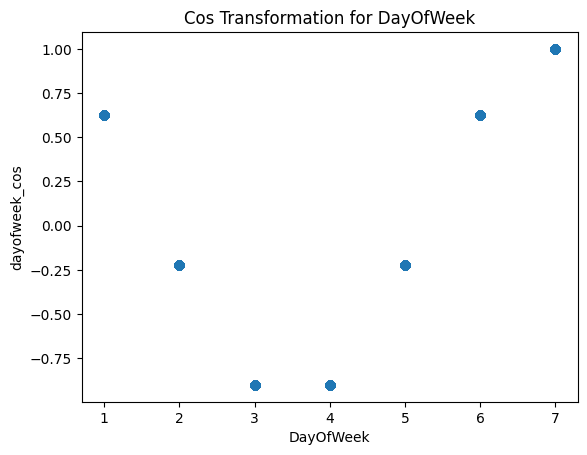

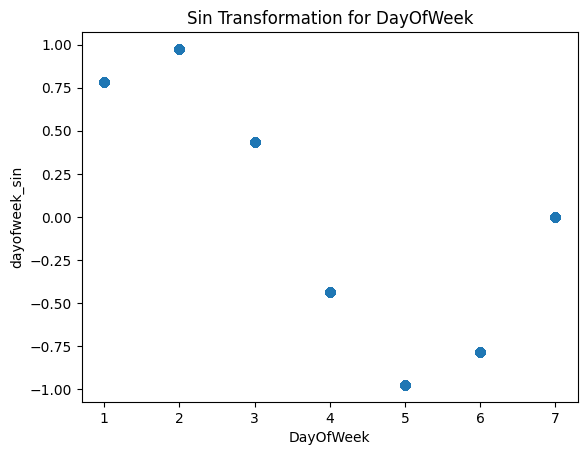

In [9]:
# Trigonometric transformation for DayOfWeek feature:
dayofweek_cos = cos_transformer(7).fit_transform(train['DayOfWeek'])
fig, ax = plt.subplots()
ax.plot(train['DayOfWeek'], dayofweek_cos, 'o')
plt.xlabel('DayOfWeek')
plt.ylabel('dayofweek_cos')
plt.title('Cos Transformation for DayOfWeek')

dayofweek_sin = sin_transformer(7).fit_transform(train['DayOfWeek'])
fig, ax = plt.subplots()
ax.plot(train['DayOfWeek'], dayofweek_sin, 'o')
plt.xlabel('DayOfWeek')
plt.ylabel('dayofweek_sin')
plt.title('Sin Transformation for DayOfWeek')

For the DayOfWeek, cos transformation may be misleading because it appears as Friday and Saturday have close values with Monday and Tuesday. Anybody who worked in a full time job can tell that these days are not close at all. And this should be applicable to aviation industry, since the flight plans are strongly related with the business days order. Therefore, **sin transformation is more appropriate for DayOfWeek.**

In [10]:
# make the transformation in train set:
train['Month_Cos'] = month_cos
train['DayofMonth_Cos'] = dayofmonth_cos
train['DayofWeek_Sin'] = dayofweek_sin

### Trigonometric transformation for Departure Time (in Military Time)
Let's see if it is useful for the time of the day also.

Text(0.5, 1.0, 'Sin Transformation for DepTime')

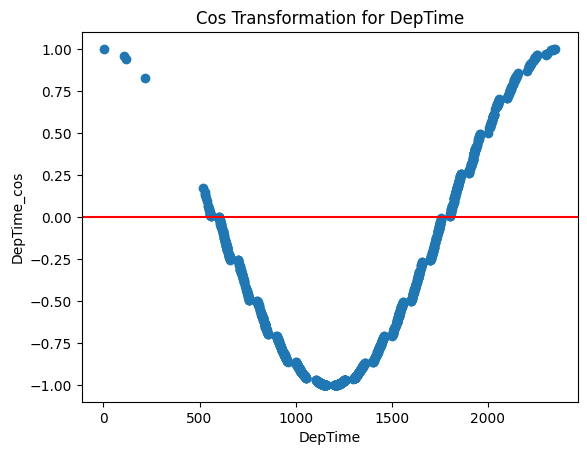

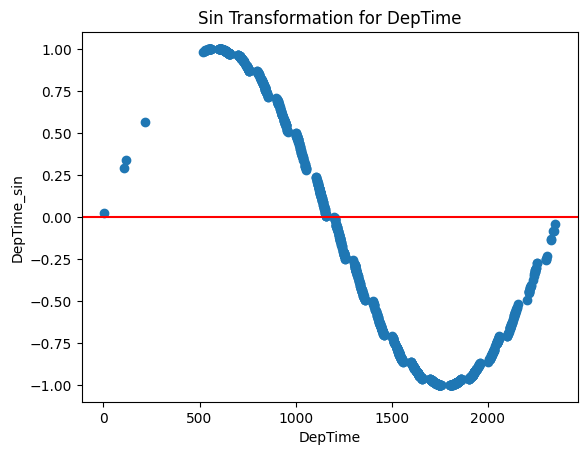

In [11]:
# this function takes the military time format and calculates the total hours passed. 
#  Military time seems a linear continuous variable, but they are not in 10-based regular numbers.
#  calculating the total hours. This is needed for our transformation approach. 
def military_to_hours(military_time):
    hour = military_time // 100
    minute = military_time % 100
    total_hours = round((hour * 60 + minute) / 60, 2)
    return total_hours


train['ith_hour'] = military_to_hours(train['DepTime'])

# trig transformations for DepTime
DepTime_cos = cos_transformer(24).fit_transform(train['ith_hour'])
DepTime_sin = sin_transformer(24).fit_transform(train['ith_hour'])



# to plot, create a data frame
dc = pd.DataFrame(data={'DepTime': train['DepTime'],
                        'DepTime_cos': DepTime_cos})

# take a sample for the plot for simplicity
s_dc = dc.sample(n=1000, random_state=123)

# plot for cos transformed DepTime
fig, ax = plt.subplots()
ax.plot(s_dc['DepTime'], s_dc['DepTime_cos'], 'o')
plt.axhline(y=0, c='r')
plt.xlabel('DepTime')
plt.ylabel('DepTime_cos')
plt.title('Cos Transformation for DepTime')


# same steps for sin transformation
ds = pd.DataFrame(data={'DepTime': train['DepTime'],
                        'DepTime_sin': DepTime_sin})

s_ds = ds.sample(n=1000, random_state=123)

fig, ax = plt.subplots()
ax.plot(s_ds['DepTime'], s_ds['DepTime_sin'], 'o')
plt.axhline(y=0, c='r')
plt.xlabel('DepTime')
plt.ylabel('DepTime_sin')
plt.title('Sin Transformation for DepTime')

For the time of the day, neither function is appropriate. For cos transformation, 5 in the morning and 5 in the evening has same values. This cannot preserve the meaning of the times. For sin transformation also, noon has same values with midnight. Because of the nature of these trigonometric functions, some outputs intersects with others.

### Radial Basis Transformation (RBF)
Another approach for time features is using RBF. Basically, this transformation creates new features indicating distance values based on a fixed point. Explained in detail on [wikipedia page](https://en.wikipedia.org/wiki/Radial_basis_function)

array([<Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>,
       <Axes: xlabel='DepTime'>, <Axes: xlabel='DepTime'>], dtype=object)

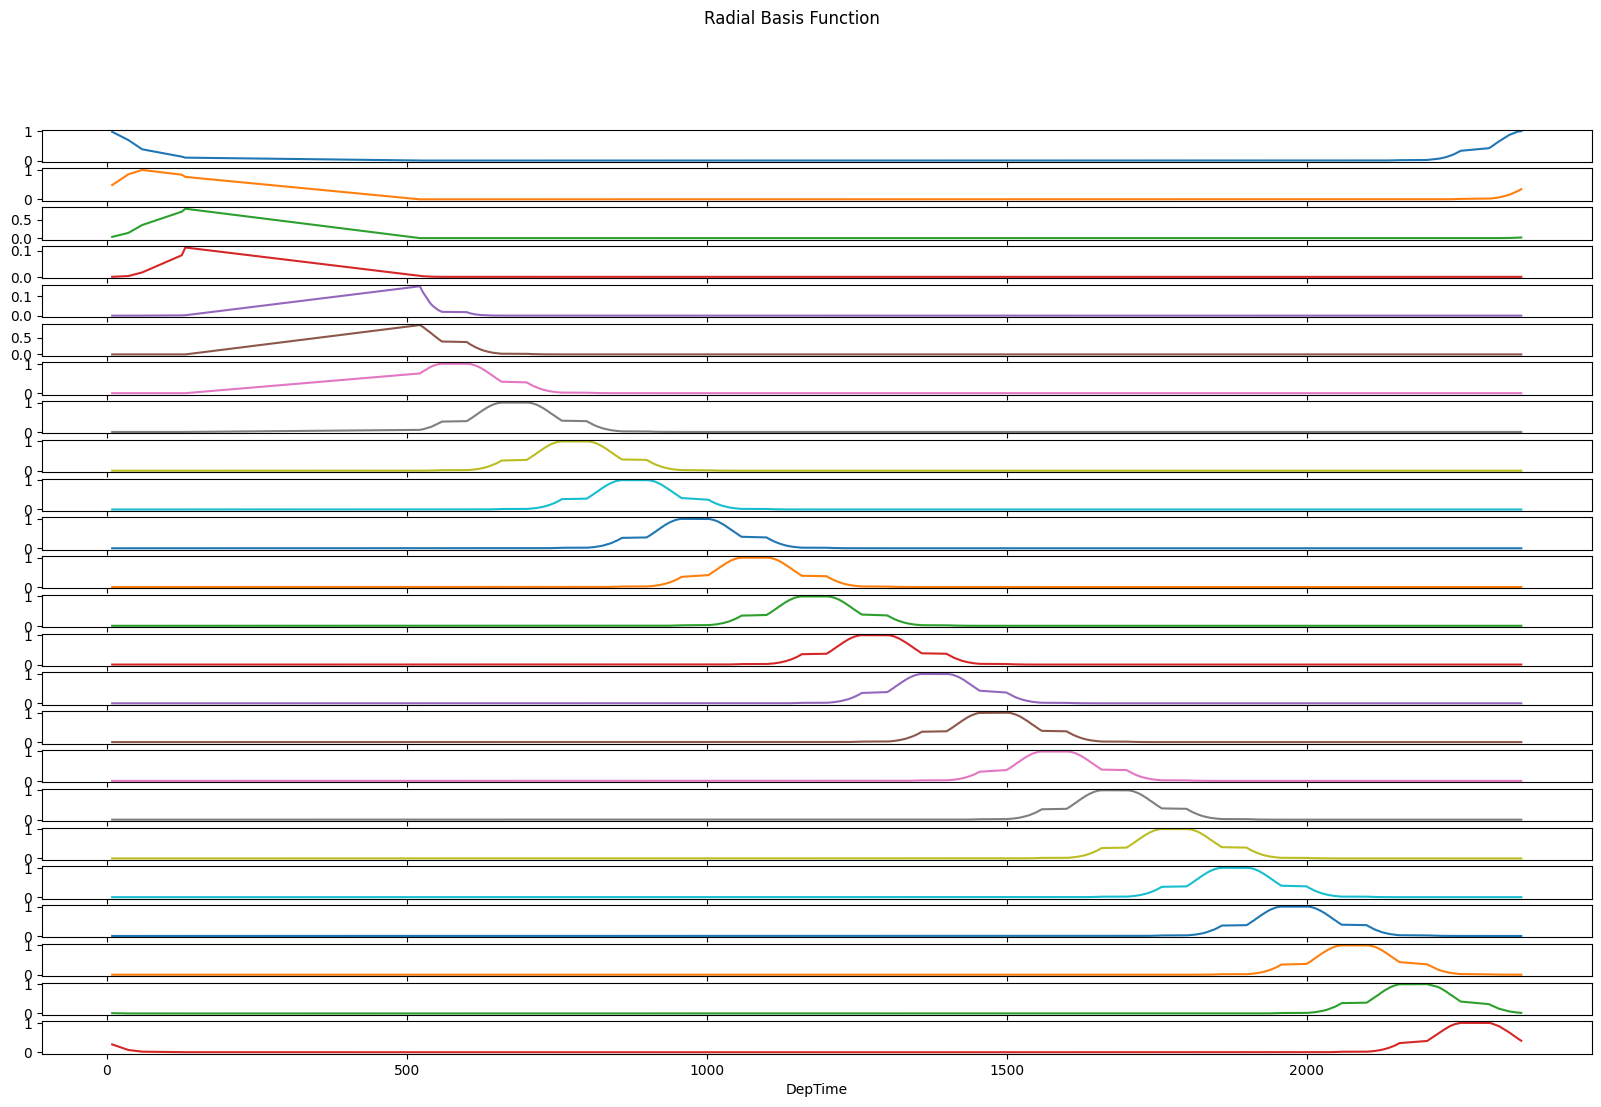

In [12]:
rbf = RepeatingBasisFunction(n_periods=24,
                             column='ith_hour',
                             input_range=(0, 24),
                             remainder='drop')

rbf.fit(train)

train_rbf = pd.DataFrame(data=rbf.transform(train), index=train['DepTime'])

train_rbf_sample = train_rbf.sample(n=1000, random_state=12)


train_rbf_sample.sort_index().plot(subplots=True, figsize=(20, 12),
                                   sharex=True, title='Radial Basis Function',
                                   legend=False)

Above plot shows new features for each hour of the day. The fixed point is around the middle of the day in our case. When a feature is closer to the fixed point, it takes values closer to 1. When a feature is far, the value stays at 0. Therefore, with the cost of adding new dimensions, we can preserve the cyclical meaning of the time, and did not create a misperception between opposite sides of AM and PM.

## Putting Them Altogether
After explaining the idea of these transformations, let's put them together. We should be doing train-valid split before the transformations so we can prevent one of the biggest sins in the area, data leakage.

In [13]:
# train-valid split first
train = pd.read_csv('/kaggle/input/flight-delays-spring-2018/flight_delays_train.csv')
test = pd.read_csv('/kaggle/input/flight-delays-spring-2018/flight_delays_test.csv')

train['dep_delayed_15min'] = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
train['DayOfWeek'] = train['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))
train['Month'] = train['Month'].apply(lambda x: int(x.split('-')[1]))
train['DayofMonth'] = train['DayofMonth'].apply(lambda x: int(x.split('-')[1]))


test['DayOfWeek'] = test['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))
test['Month'] = test['Month'].apply(lambda x: int(x.split('-')[1]))
test['DayofMonth'] = test['DayofMonth'].apply(lambda x: int(x.split('-')[1]))

# target feature is unbalanced
print('delay to not delay ratio:', sum(train['dep_delayed_15min'])/len(train['dep_delayed_15min']))

X_train, y_train = train.drop(['dep_delayed_15min'], axis=1), train['dep_delayed_15min']

X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train, y_train,
    test_size=0.3, random_state=17,
    stratify=y_train # stratify with y because of the imbalance 
)

delay to not delay ratio: 0.19044


In [14]:
# trig transformations

# fit with train part
X_train_part['Month'] = cos_transformer(12).fit_transform(X_train_part['Month'])
X_train_part['DayofMonth'] = cos_transformer(30).fit_transform(X_train_part['DayofMonth'])
X_train_part['DayOfWeek'] = sin_transformer(7).fit_transform(X_train_part['DayOfWeek'])

# only transform the valid and test parts. prevent data leakage.
X_valid['Month'] = cos_transformer(12).transform(X_valid['Month'])
X_valid['DayofMonth'] = cos_transformer(30).transform(X_valid['DayofMonth'])
X_valid['DayOfWeek'] = sin_transformer(7).transform(X_valid['DayOfWeek'])

# only transform the valid and test parts. prevent data leakage.
test['Month'] = cos_transformer(12).transform(test['Month'])
test['DayofMonth'] = cos_transformer(30).transform(test['DayofMonth'])
test['DayOfWeek'] = sin_transformer(7).transform(test['DayOfWeek'])

In [15]:
# RBF transformation
X_train_part['ith_hour'] = military_to_hours(X_train_part['DepTime'])
X_valid['ith_hour'] = military_to_hours(X_valid['DepTime'])
test['ith_hour'] = military_to_hours(test['DepTime'])

rbf = RepeatingBasisFunction(n_periods=24,
                             column='ith_hour',
                             input_range=(0, 24),
                             remainder='drop')

rbf.fit(X_train_part) # fitted and transformed only using train part.


RepeatingBasisFunction(column='ith_hour', input_range=(0, 24), n_periods=24)

In [16]:
# To not cause a confusion here:
#  When making RBF transformation, I dropped other columns and created a new df
#  only with RBF transformed values. Because when not dropped, it changes all the column names 
#  and it becomes a mess. creating RBF transformed values, then concatinating with the datasets
#  seemed easier.

# it is fitted only with train part, no leakage
train_rbf = pd.DataFrame(data=rbf.transform(X_train_part), index=X_train_part.index)
X_train_part_RBFd = pd.concat([X_train_part, train_rbf], axis=1)

valid_rbf = pd.DataFrame(data=rbf.transform(X_valid), index=X_valid.index)
X_valid_RBFd = pd.concat([X_valid, valid_rbf], axis=1)


test_rbf = pd.DataFrame(data=rbf.transform(test), index=test.index)
test_RBFd = pd.concat([test, test_rbf], axis=1)

In [17]:
# these columns are transformed and not needed anymore
X_train_part_RBFd = X_train_part_RBFd.drop(['ith_hour', 'DepTime'], axis=1)
X_valid_RBFd = X_valid_RBFd.drop(['ith_hour', 'DepTime'], axis=1)
test_RBFd = test_RBFd.drop(['ith_hour', 'DepTime'], axis=1)

## CatBoost Model
We are left with UniqueCarrier, Origin, and Dest as categorical and others as numeric features. As the name suggest, CatBoost is quite easy to use with categorical features. I am not doing any encoding for these categorical ones and leave for the model to work it's magic.

I tried a GridSearch before and obtained some optimized parameters. To not inflate the notebook and spend too much time for cross validation, I will be using these parameters since this practice is focused more on the feature engineering part.

In [18]:
from catboost import CatBoostClassifier

cat_features_indices = np.where(X_train_part_RBFd.dtypes == object)[0]

cat = CatBoostClassifier(
    subsample=0.75,
    early_stopping_rounds=20,
    eval_metric='AUC',
    random_seed=12,
    cat_features=cat_features_indices,
    learning_rate=0.1,
    max_depth=5,
    reg_lambda=5.0,
    # 'scale_pos_weight': 4 use this if it is more important to correctly predict the delays
    # mean 1 rate is 0.19. suggested weight sum(neg instances) / sum(pos instances) = 4.23
)

cat.fit(
    X_train_part_RBFd, y_train_part,
    eval_set=(X_valid_RBFd, y_valid),
    verbose=1,
)

0:	test: 0.6955253	best: 0.6955253 (0)	total: 135ms	remaining: 2m 14s
1:	test: 0.6954984	best: 0.6955253 (0)	total: 210ms	remaining: 1m 44s
2:	test: 0.6982920	best: 0.6982920 (2)	total: 285ms	remaining: 1m 34s
3:	test: 0.6992321	best: 0.6992321 (3)	total: 372ms	remaining: 1m 32s
4:	test: 0.6996291	best: 0.6996291 (4)	total: 474ms	remaining: 1m 34s
5:	test: 0.6996960	best: 0.6996960 (5)	total: 540ms	remaining: 1m 29s
6:	test: 0.7002026	best: 0.7002026 (6)	total: 603ms	remaining: 1m 25s
7:	test: 0.7004499	best: 0.7004499 (7)	total: 669ms	remaining: 1m 23s
8:	test: 0.7005312	best: 0.7005312 (8)	total: 737ms	remaining: 1m 21s
9:	test: 0.7014270	best: 0.7014270 (9)	total: 804ms	remaining: 1m 19s
10:	test: 0.7031412	best: 0.7031412 (10)	total: 874ms	remaining: 1m 18s
11:	test: 0.7036096	best: 0.7036096 (11)	total: 932ms	remaining: 1m 16s
12:	test: 0.7045118	best: 0.7045118 (12)	total: 992ms	remaining: 1m 15s
13:	test: 0.7051206	best: 0.7051206 (13)	total: 1.06s	remaining: 1m 14s
14:	test: 0.

In [19]:
cat.best_score_

{'learn': {'Logloss': 0.39021518256684334},
 'validation': {'Logloss': 0.41696001212126277, 'AUC': 0.7514782078489586}}

We have 0.7514 AUC score in validation set. In the before mentioned competition, this score puts us in top 3 submissions. However, when predicted on the test set, the AUC score drops to 0.7104. This means that it can be improved for the overfitting aspect.

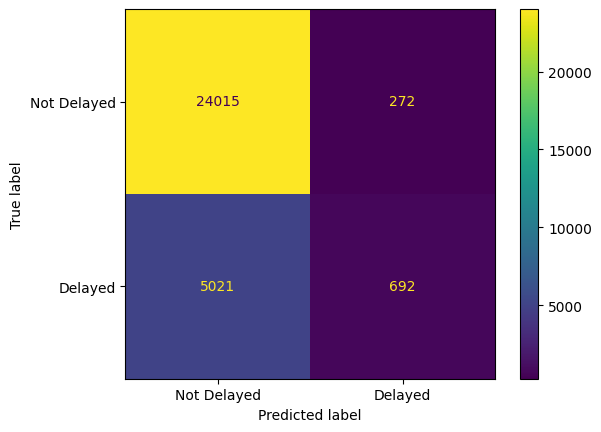

In [20]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    cat,
    X_valid_RBFd,
    y_valid,
    display_labels=['Not Delayed', 'Delayed']
)

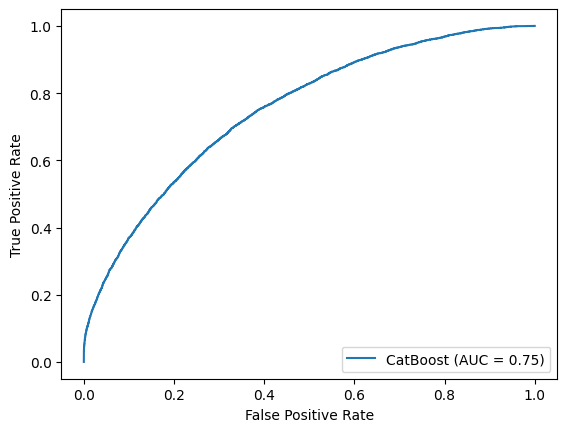

In [21]:
# ROC_AUC Curve
cat_pred_proba = cat.predict_proba(X_valid_RBFd)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, cat_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='CatBoost')
display.plot()
plt.show()

# might not look ideal but the first place in leaderboard has a auc score of 0.7601

## Conclusion
In this notebook, I tried trigonometric and RBF transformations for cyclical features, such as time of the day, day of month, and month of the year. With this approach, instead of taking the time features linearly, we preserved the cyclical meaning of them. Prevented categorical approaches to time features and inflating the data with many new columns. Obtained well results in classification setting. Thanks for your interest.